# Ensemble Learning and Random Forests

If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble, thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method.

For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all individial trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a Random Forest.

In this notes we will discuss the most popular Ensemble methods, including bagging, boosting, stacking, and a few others. We will also explore Random Forest method.

## Setup

In [2]:
import sys
import sklearn
import numpy as np
import os
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'ensembles'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

## Voting Classifiers

Suppose you have trained a few classifiers, each one achieving about 80% accuracy, a very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier.

Somewhat surprisingly is, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner, the ensamble can still be a strong learner, provided there are a sufficient number of weak learners and they are sufficiently diverse.

But in order to get a better accuracy all the classifiers must be perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble's accuracy.

One way to avoid this is to get diverse classifiers trained on very different algorithms. This increase the chance that thet will make very different types of errors, improving the ensemble's accuracy

The following code creates an trains a voting classifier in Scikit-Learn, using three diverse classifiers, the training set is the moons dataset.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [8]:
log_clf = LogisticRegression(solver='lbfgs',random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', random_state=42)

In [9]:
voting_clf = VotingClassifier(
    estimators=[('lr',log_clf),('rf', rnd_clf),('svc', svm_clf)],
    voting='hard')

In [10]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Now let's look at each classifier's accuracy on the test set:

In [11]:
from sklearn.metrics import accuracy_score

In [13]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


There you have it! The voting classifier slightly outperforms all the individual classifiers

Another way to make the voting classifier is to set the hyperparameter as soft, with voting="soft", Scikit-Learn will predict the class with the highest probability and averaged over all the individual classifiers. But we need to ensure that all classifiers can estimate class probabilities. All are based in probabilities except for the SVC class, but we can adjust it by changing the probability hyperparameter to True, this will make the SVC class use cross-validation to estimate class probabilities. Let's check how does the accuracy change

In [15]:
log_clf = LogisticRegression (solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [16]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


Great the accuracy just rose up to 92%

## Bagging and Pasting

Bagging and Pasting is another approach, it relies in using the same training algorithms for every predictor, but to train them on different random subsets of the training set. If the sampling is performed with replacement, this method is called bagging (short for bootstrap aggregating). When sampling is performed without replacement, it is called pasting.

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictor. The aggregation function is typically the statistical mode for classification, or the average for regression.

Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClassifier class (or BaggingRegressor for regression). The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set with replacement (bagging).

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [26]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)

In [27]:
y_pred = bag_clf.predict(X_test)

Let's check for the accuracy score

In [28]:
print(accuracy_score(y_test,y_pred))

0.904


and compare it with a normal Decision Tree Classifier

In [29]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test,y_pred_tree))

0.856


As we can see the ensemble's predictions generalize much better than the single Decision Tree's predictions. In the figure below we compare the decision boundary of the single Decision Tree with the decision boundary of a bagging ensemble of 500 trees

In [30]:
from matplotlib.colors import ListedColormap

In [33]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1,x2,y_pred,alpha=0.3,cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:,0][y==0], X[:,1][y==0], 'yo', alpha=alpha)
    plt.plot(X[:,0][y==1], X[:,1][y==1], 'bs', alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18, rotation=0)

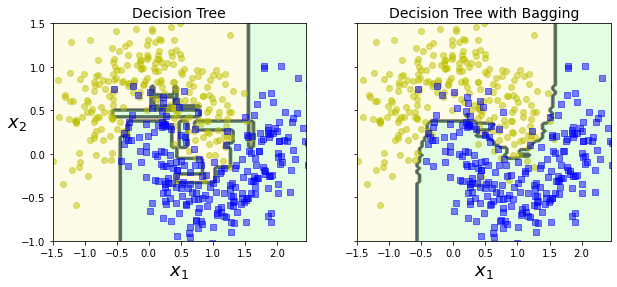

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title('Decision Tree', fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title('Decision Tree with Bagging', fontsize=14)
plt.ylabel('')
plt.show()

### Out-of-bag evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called out of bag (oob) instances. 

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. It can be evaluated the ensemble itself by averaging out the oob evaluations of each predictor.

In Scikit-Learn, you can set oob_score=True when creating the BaggingClassifier to request an automatic oob evaluation after training. 

In [35]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

According to this oob evaluation, the BaggingClassifier is likely to achieve about 89.8% accuracy on the test set. Let's verify this

In [36]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

We obtained a 91.2 that is close enough.

Also the oob decision function for each training instance is also available through the oob_decision_function_ variable.

In [ ]:
bag_clf.oob_decision_function_ # The code is not run in order to reduce spaces in the printing view

## Random Forests

A Random Forests is an ensemble of Decision Tree, generally trained via the bagging method, typically with max_samples set to the size of the training set. Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees.

The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores.

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [41]:
y_pred_rf = rnd_clf.predict(X_test)

Let's check for its accuracy

In [42]:
accuracy_score(y_test,y_pred_rf)

0.92

Great it's the higher accuracy so far

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees: instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features, yielding an overall better model. But let's compare it with a BaggingClassifier of DecisionTreeClassifier

In [44]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes = 6),
    n_estimators = 500, random_state = 42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [45]:
np.sum(y_pred == y_pred_rf) /len(y_pred)

1.0

In conlusion they have very similar predictions.

### Feature Importance

Another quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature's importance by looking at how much the tree nodes that use that feature reduce impurity on average. It is a weighted average, where each node's weight is equal to the number of training samples that are associated with it. Then Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1.

To get it we can use the feature_importances_ variable. Let's check it in the Iris dataset

In [46]:
from sklearn.datasets import load_iris

In [48]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


So it seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparision (11% and 2% respectively)

Similarly, if we train a RandomForest classifier on the MNIST dataset, and plot each pixel's importance, you get the figure below

In [49]:
from sklearn.datasets import fetch_openml

In [50]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [51]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(random_state=42)

In [55]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap = mpl.cm.hot,
              interpolation='nearest')
    plt.axis('off')

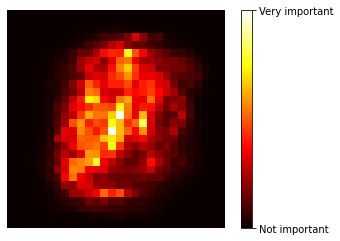

In [58]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks = [rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## Boosting

Boosting refers to any Ensemble method that can combine several weak learners into a strong learner. The idea is to train predictors sequentially, each trying to correct its predecessor. The two most popular are AdaBoost (Adaptive Boosting) and Gradient Boosting

### AdaBoost

AdaBoost makes a new predictor by correcting its predecessor by paying a bit more attention to the training instances that the predecessor underfitted. This result in new predictors focusing more and more on the hard classes.

The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn's AdaBoostClassifier class. A Decision Stump is a Decision Tree with max_depth=1 a tree composed of a single decision node plus two leaf nodes. The model is trained on the moons dataset

In [59]:
from sklearn.ensemble import AdaBoostClassifier

In [60]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)

In [62]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

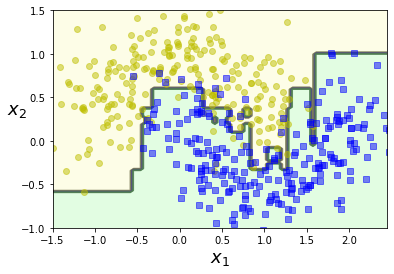

In [63]:
plot_decision_boundary(ada_clf, X, y)

In the figure below, it shows the decision boundaries of five consecutive predictors on the moons dataset (the predictor is regularized SVM classifier with an RBF kernel). It can be seen in the left graph that the first classifier gets many instances wrong, so their weights get boosted. The second classifier does a better job on these instances, and so on. The plot on the right represents the same sequence of predictors, except that the learning rate is halved.

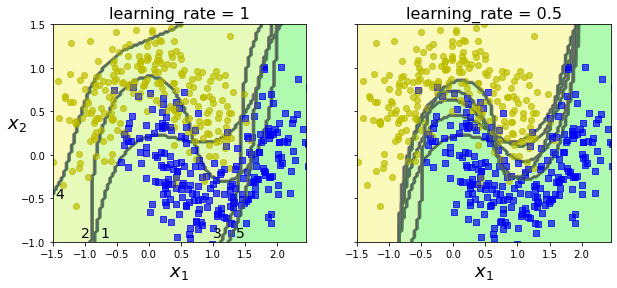

In [67]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0,1),(1,0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel='rbf', C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        alpha = learning_rate * np.log((1 - r) / r)
        sample_weights[y_pred != y_train] *= np.exp(alpha)
        sample_weights /= sample_weights.sum()
        
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title('learning_rate = {}'.format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, '1', fontsize=14)
        plt.text(-1.05, -0.95, '2', fontsize=14)
        plt.text(1.0, -0.95, '3', fontsize=14)
        plt.text(-1.45, -0.5, '4', fontsize=14)
        plt.text(1.36, -0.95, '5', fontsize=14)
    else:
        plt.ylabel('')
        
plt.show()

### Gradient Boosting

The Gradient Boosting works like AdaBoost by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

For this example let's take a noisy quadatric training set, then it will be a regression example, using a Decision Tree as the base predictors. This is called Gradient Boosted Regression Trees (GBRT).

In [93]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [94]:
from sklearn.tree import DecisionTreeRegressor

In [95]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Next, we'll train a second DecisionTreeRegressor on the residual errors made by the first predictor

In [96]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:

In [97]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a neew instance simply by adding up the predictions of all the trees:

In [98]:
X_new = np.array([[0.8]])

In [99]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [100]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left columns, and the ensemble's predictions in the right column. The first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree's predictions. The second row, a new tree is trained on the residual errors of the first tree, and in the right one the ensemble's predictions can be seen and are equal to the sum of the predictions of the first two tree. In the third row another tree is trained on the residual errors of the second tree. The ensemble's predictions gradually get better as trees are added to the ensemble.

In [101]:
def plot_predictions(regressors, X, y, axes, label=None, style='r-', data_style='b.', data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1,1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)

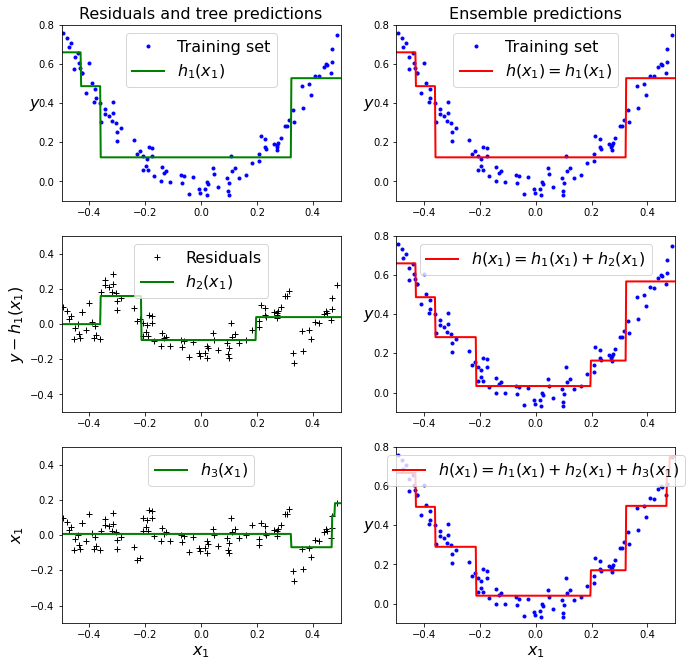

In [104]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h_1(x_1)$', style='g-', data_label='Training set')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title('Residuals and tree predictions', fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h(x_1) = h_1(x_1)$', data_label='Training set')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title('Ensemble predictions', fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label='$h_2(x_1)$', style='g-', data_style='k+', data_label='Residuals')
plt.ylabel('$y - h_1(x_1)$', fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h(x_1) = h_1(x_1) + h_2(x_1)$')
plt.ylabel('$y$', fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label='$h_3(x_1)$', style='g-', data_style='k+')
plt.ylabel('$x_1$', fontsize=16)
plt.xlabel('$x_1$', fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$')
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

plt.show()

A simple way to traing GBRT ensembles is to use Scikit-Learn's GradientBoostingRegressor class. Let's make the code

In [105]:
from sklearn.ensemble import GradientBoostingRegressor

In [107]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

An important hyperparameter in Gradient Boosting is the learning_rate, with lower values will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. In the figure below there are two GBRT, one with a learning_rate of 1 and the other with a learning_rate of 0.1

In [110]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X,y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

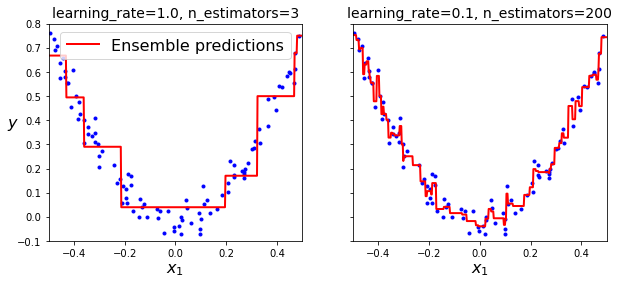

In [112]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='Ensemble predictions')
plt.title('learning_rate={}, n_estimators={}'.format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title('learning_rate={}, n_estimators={}'.format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel('$x_1$', fontsize=16)

plt.show()

### Gradient Boosting with Early stopping

To find the optimal number of trees, you can use early stopping. A way to implement it, is using the staged_predict() method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc). The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, at the end it trains another GBRT ensemble using the optimal number of trees:

In [113]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [114]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

In [115]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators= bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

The validation errors are represented on the left of the below figure, and the best models predictions are represented on the right

In [116]:
min_error = np.min(errors)

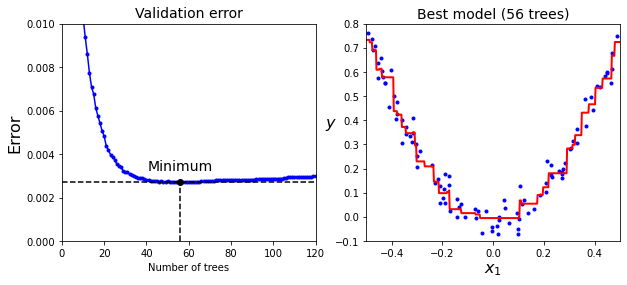

In [118]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, 'b.-')
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], 'k--')
plt.plot([0,120], [min_error, min_error], 'k--')
plt.plot(bst_n_estimators, min_error, 'ko')
plt.text(bst_n_estimators, min_error*1.2, 'Minimum', ha='center', fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel('Number of trees')
plt.ylabel('Error', fontsize=16)
plt.title('Validation error', fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title('Best model (%d trees)' %bst_n_estimators, fontsize=14)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.xlabel('$x_1$', fontsize=16)

plt.show()

It's also possible to implement early stopping. You can do so by setting warm_start=True, which makes Scikit-Learn keep existing tree when the fit() method is called, allowing incremental training. The following codes stops when the validation error does not improve for five iterations in a row:

In [119]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

In [120]:
min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break
            

Now we can know the best n_estimator just by subtracting 5 from the gbrt.n_estimators

In [123]:
print(gbrt.n_estimators - 5)

56


In [122]:
print('Minimum validation MSE', min_val_error)

Minimum validation MSE 0.002712853325235463


## XGBoost

An optimized implementation of the Gradient Boosting is available in the library XGBoost, which stands for Extreme Gradient Boosting. It aims to be extremely fast, scalable and portable. Lets see how it works

In [127]:
import xgboost

In [129]:
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print('Validation MSE: ', val_error)

Validation MSE:  0.004000408205406276


XGBoost also offers several nice features, such as automatically taking care of early stopping

In [130]:
xgb_reg.fit(X_train, y_train,
           eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print('Validation MSE: ', val_error)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE:  0.002630868681577655


/Users/Frank/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
